In [118]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import emcee

In [2]:
class CanonicalParabola:
    def __init__(self, a, b, c):
        self.a = a
        self.b = b
        self.c = c
    def printparam(self):
        print("a = {0} \nb = {1} \nc = {2} \n".format(self.a, self.b, self.c))
    
    def discriminant(self):
        return self.b**2 - 4*self.a*self.c
    
    def findIntersection(self):
        if(self.discriminant() > 0):
            return (-self.b - np.sqrt(self.discriminant()))/(2*self.a), (-self.b + np.sqrt(self.discriminant()))/(2*self.a)
        else:
            print("Sorry...no real solutions")
    
    def integrate(self, x1, x2):
        return integrate.quad(lambda x: self.a*x**2 +self.b*x+self.c, x1, x2)
    
    def value(self,x):
        return self.a*x**2 + self.b*x + self.c

In [3]:
x = CanonicalParabola(1,2,-1)

In [4]:
x.findIntersection()

(-2.414213562373095, 0.41421356237309515)

In [5]:
x.integrate(0,2)

(4.666666666666666, 5.666271351443603e-14)

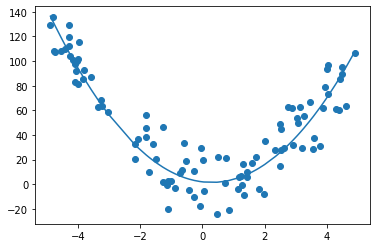

In [175]:
a_true = 5
b_true = -3
c_true = 2
f_true = 0.01
myParabola = CanonicalParabola(5, -3, 2)

x = np.sort(np.random.uniform(-5,5, size = 100))
y_true = myParabola.value(x)
yerr = np.random.normal(loc=0.0, scale=15.0, size=100)
y = y_true+yerr
plt.plot(x,y_true)
plt.scatter(x,y)

In [176]:
with open('output.txt','w') as f:
    f.write('x \t y \t yerr \n')
    for i in range(len(x)):
        f.writelines("%.3f\t %.3f\t %.3f"%(x[i], y[i], yerr[i]))
        f.write('\n')
f.close()

In [187]:
yerr=y*0.8
def log_likelihood(theta, x, y, yerr):
    a, b, c, log_f = theta
    model = a * x**2 + b*x + c
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Success status: False
Desired error not necessarily achieved due to precision loss.
Maximum likelihood estimates:
a = 2.1590 (True: 5.0000)
b = -0.5433 (True: -3.0000)
c = -2.8552 (True: 2.0000)
f = 0.7091 (True: 0.0100)


C:\Users\Admin\AppData\Local\Temp/ipykernel_10272/153607692.py:5: RuntimeWarning: overflow encountered in exp
  sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
C:\Users\Admin\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Admin\AppData\Local\Temp/ipykernel_10272/153607692.py:5: RuntimeWarning: overflow encountered in exp
  sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)


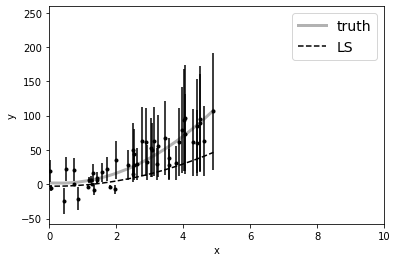

In [188]:
from scipy.optimize import minimize

# Reproducible results
np.random.seed(42)

# Function to minimize: the negative log-likelihood (nll)
nll = lambda *args: -log_likelihood(*args)

# Initial guess for the parameters (make it imperfect with Gaussian noise)
initial = np.array([a_true, b_true, c_true, np.log(f_true)]) + 0.1 * np.random.randn(4)

# Solve by minimization of -log-likelihood!
soln = minimize(nll, initial, args=(x, y, yerr))

# Check it converged
print("Success status:", soln.success)
print(soln.message)

# Extract maximum likelihood parameter values
a_ml, b_ml, c_ml, log_f_ml = soln.x
print("Maximum likelihood estimates:")
print("a = {0:.4f} (True: {1:.4f})".format(a_ml, a_true))
print("b = {0:.4f} (True: {1:.4f})".format(b_ml, b_true))
print("c = {0:.4f} (True: {1:.4f})".format(c_ml, c_true))
print("f = {0:.4f} (True: {1:.4f})".format(np.exp(log_f_ml), f_true))

# Plot all together
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, a_true*x**2 + b_true*x + c_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x, a_ml*x**2 + b_ml*x + c_ml, "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [189]:
def log_prior(theta):
    a, b, c, log_f = theta
    # Return a finite value if theta is in the parameter space region with support for the prior
    if -10.0 < a < 10.0 and -10.0 < b < 10.0 and -10.0 < c < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    # Otherwise return -infinity, basically a massive down-weight for the posterior
    return -np.inf

In [190]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    # If theta is outside the support for the prior, return -infinity
    if not np.isfinite(lp):
        return -np.inf
    # Otherwise return the logarithm of prior*likelihood
    return lp + log_likelihood(theta, x, y, yerr)

In [191]:
# The number of walkers
nwalkers = 256

# The dimensionality of the parameter space (m, q, ln(f))
ndim = 4

# The MCMC steps
nmcmc = 5000

# Initial position
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
pos
# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, nmcmc, progress=True); # The ; avoids some prints to screen

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:55<00:00, 90.28it/s]


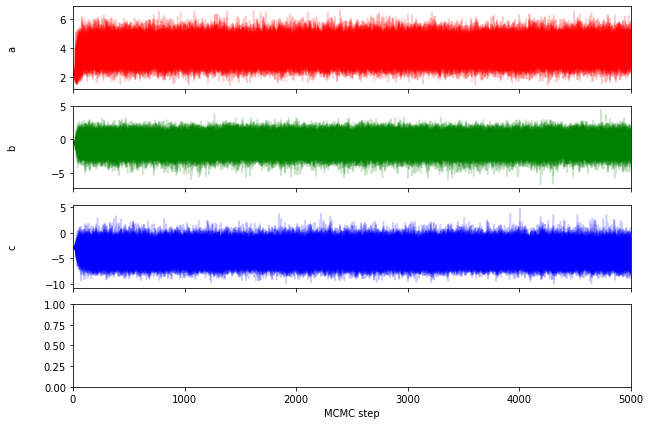

In [192]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "log(f)"]
col = ['r', 'g', 'b']
for i in range(0,3):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2) # 
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step"); # The ; avoids an unwanted output to screen.

In [193]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(62720, 4)


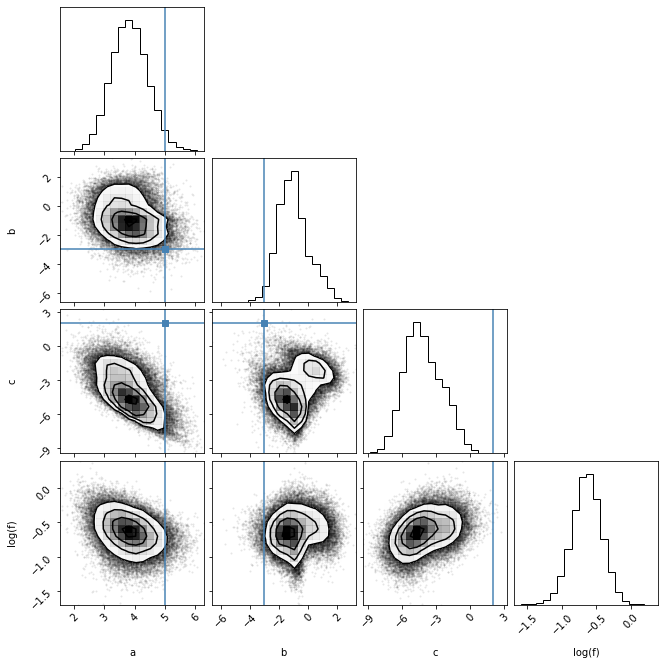

In [194]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=[a_true, b_true, c_true, np.log(f_true)])